In [1]:
pwd


'/fs/ess/PCON0160/ben/pipelines/metagene_analysis'

# *Metagenome analysis pipeline part 2/2*

First run align.sh to align and normalize sequencing reads. Then use this to visualize the metagene pattern.

This pipeline is designed to be used primarily with small RNA sequencing data but can be adapted to all sequencing methods.

Inputs :
* bed file **or** directory with bed files
    * the form of bedfiles is as follows
        1. chrom (or gene)
        2. start pos of read
        3. end pos of read
        4. sequence of read
        5. abundance of the read
        6. strand
* transcript fasta file or bed windows
    * if using bed windows reads that fall witin these windows will be counted, if scaling is enabled the size of the window will be used for scaling.
        * Format 
            1. chrom (or gene)
            2. start 
            3. end
    * if transcript fasta file is provided but not bed windows, the length of the transcripts will be used for scaling.
    
Other parameters : 
* scaling --> default is True
* sample --> if None will use basename of bed file with reads.
* 5' nucleotide (p5nt) --> G or A
* min_len --> 21 nt
* max_len --> 23 nt


Tip :  
* use %%bash in cell to reformat bed.tsv file from output of nextflow_smRNA pipeline

**If using bed directory with bed files, use run_metagene_multi(), otherwise can use run_metagene()**

In [1]:
import os
import sys
import pandas as pd 
import argparse
import numpy as np 
import glob
import time 
import logging
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import pickle

In [2]:
def summarise_target_transcripts(bed_file) :
    
    bed = pd.read_csv(bed_file, 
                    sep = "\t",
                    usecols = [0,1,2,6,7,8],
                    names = ['chrom', 'start', 'end', 'transcript_start', 'transcript_end', 'ee_junc'])

    print(bed.head())
    
    bed = bed.query("transcript_end < 10000")

    print(f"Mean transcript length: {bed['transcript_end'].mean()}")

    print(f"Median transcript length: {bed['transcript_end'].median()}")
    
    fig, ax =plt.subplots(1,2)
    
    p = sns.histplot(data=bed, x="transcript_end", ax=ax[0])
    
    bed['scaled_ee_junc'] = 100*(bed['ee_junc'] / bed['transcript_end'])
    
    
    p1 = sns.histplot(data=bed, x="scaled_ee_junc", ax=ax[1])
    fig.show()

In [3]:
def plot_metagene(result, plot_group = 'alias', facet_by = None, x_col = 'pos', y_col = 'count', shade = None, title = None, sharey = False, vline = False) : 
    
    plot = sns.FacetGrid(result, 
                         col = facet_by, 
                         hue = plot_group, 
                         height = 4, 
                         aspect = 2)
    
    plot.map(sns.lineplot, x_col, y_col)

    plot.add_legend()
    
    if shade : 
            result['m'] = result[y_col] - result[shade]
            result['M'] = result[y_col] + result[shade]
            plot.map(plt.fill_between, x_col, 'm', 'M', alpha=0.2)
            
    if vline : 
        plt.axvline(x = vline, color = 'grey', label = f'{vline} bp', alpha = 0.5)
    
    
    if title : 
        plot.fig.suptitle(f'{title}')
    
    return plot

In [4]:
def merge_and_plot(conditions, result, count = 'count', vline = False) :
    
    result_merge = result.merge(
        conditions, how = 'left', left_on = 'alias', right_on = 'simple_name')
    
    result_grouped = result_merge.groupby(
        ['pos', 'type', 'condition']
    ).agg(
        M = (count, 'mean'),
        S = (count, 'std')
    ).reset_index()
    
    plot_metagene(result_grouped, 
                  shade = 'S', 
                  facet_by='type', 
                  x_col = 'pos', 
                  y_col = 'M', 
                  plot_group = 'condition',
                  vline = vline
                 )

In [5]:
def parse_transcripts(transcripts) : 
    
    sizes = {}
    seqs = {}
    seq = ''
    i = 0
    with open(transcripts, 'r') as f : 
        for line in f :
            if line.startswith(">") :
                info = line.strip().replace(">","")
                if i == 1 :
                    seqs[info] = seq 
                    sizes[info] = len(seq)
                    seq = ''
                    i = 0
                i += 1
            else : 
                seq += line.strip()
                
    return seqs, sizes

In [6]:
def parse_windows(bed_windows) : 

    windows = {}
    with open(bed_windows, 'r') as f : 
        for line in f : 
            info = line.strip().split("\t")
            gene = info[0]
            start = int(info[1])
            end = int(round(float(info[2])))

            if gene in windows.keys() : 
                windows[gene].append([start, end])
            else : 
                windows[gene] = [ [start, end] ]
    return windows

In [7]:
def calculate_coverage(bed) : 
    
    bed_entries = 0 
    with open(bed, 'r') as f : 
        for line in f : 
            bed_entries += 1
    f.close()
    print(f"{bed_entries} total bed entries...")
    
    cov = {}
    bed_line = 0
    with open(bed, 'r') as f :
        for line in f : 
            if not (line.startswith('chrom')) and not (line.startswith("gene_name")) : 
                info = line.strip().split('\t')
                chrom = info[0]
                start = int(info[1])
                end = int(info[2])
                seq = str(info[3])
                count = float(info[4])
                
                # make a dict for each gene
                if not chrom in cov.keys() : 
                    cov[chrom] = {}
                
                for i in range(start, end + 1) :
                    if i in cov[chrom].keys() : 
                        cov[chrom][i] += ( count / len(seq) )
                    else : 
                        cov[chrom][i] = ( count / len(seq) )
                        
            bed_line += 1
            print(f'{bed_line} of {bed_entries} ({ round(( (bed_line)/(bed_entries) )*100,2) }%) total bed entries', end='\r')
    f.close() 
    
    pklf = f"{bed}.cov.pickle"
    with open(pklf, 'wb') as handle : 
        pickle.dump(cov, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
    return cov
    

In [8]:
def adjust_pos(pos) : 
    
    if not pos == 100 and not pos == 0 : 
        return pos
    elif pos == 100 : 
        return 99.8
    else : 
        return 0.2

In [9]:
def sum_metagene_count_per_gene(bed, windows = None, scaling = False, transcript_sizes = None, sample = None, p5nt = ['G', 'A'], min_len = 21, max_len = 23) :
    
    time1 = time.time()
        
    pklf = f"{bed}.cov.pickle"
    if not os.path.exists(pklf) : 
        cov = calculate_coverage(bed)
    else : 
        with open(pklf, 'rb') as handle : 
            cov = pickle.load(handle)
    
    sample = os.path.basename(bed).split(".")[0]

    counts = []
    genes = []
    if windows : 
        total_windows = len(windows.keys())
        tracker = 0
        for gene,win_coord in windows.items() :
            for sub_win in win_coord :
                if gene in cov.keys() :
                    val = sum( [v for k,v in cov[gene].items() if sub_win[0] <= k <= sub_win[1]])
                    if val :
                        win_size = sub_win[1] - sub_win[0] + 1
                        genes.append(gene)
                        counts.append(val/win_size)
                            
           # tracker += 1
            #print(f'{tracker} of {total_windows} ({ round(( (tracker)/(total_windows) )*100,2) }%) windows processed', end='\r')
    else : 
        total_genes = len(cov.keys())
        tracker = 0
        for gene,subdict in cov.items() :
            val = sum(list(subdict.values()))
            if val :
                if gene in count.keys() : 
                    print("Multiple windows for 1 gene...exiting")
                    return 0
                else : 
                    genes.append(gene)
                    counts.append(count)
    
    df = pd.DataFrame({
        'gene' : genes, 
        f'{sample}' : counts
    })
    
    return df


In [10]:
def calculate_metagene_coord(bed, windows = None, scaling = False, transcript_sizes = None, sample = None, p5nt = ['G', 'A'], min_len = 21, max_len = 23) :
    
    time1 = time.time()
        
    pklf = f"{bed}.cov.pickle"
    if not os.path.exists(pklf) : 
        cov = calculate_coverage(bed)
    else : 
        with open(pklf, 'rb') as handle : 
            cov = pickle.load(handle)
    
    positions = []
    counts = []
    if windows : 
        total_windows = len(windows.keys())
        tracker = 0
        for gene,win_coord in windows.items() :
            for sub_win in win_coord :
                if gene in cov.keys() : 
                    cov_sub = { k:v for k,v in cov[gene].items() if sub_win[0] <= k <= sub_win[1] }

                    if bool(cov_sub) : 
                        win_size = sub_win[1] - sub_win[0] + 1

                        if scaling :
                            cov_sub_scaled = [ [(round(100*( (k-sub_win[0])/win_size)*5)/5), v] for k,v in cov_sub.items() ] 
                        else :
                            cov_sub_scaled = [ [(k-sub_win[0]), v] for k,v in cov_sub.items() ]

                        positions.extend([ i[0] for i in cov_sub_scaled ])
                        counts.extend([ i[1] for i in cov_sub_scaled ])
            tracker += 1
            print(f'{tracker} of {total_windows} ({ round(( (tracker)/(total_windows) )*100,2) }%) windows processed', end='\r')

                
    # if no windows are specified
    else :
        total_genes = len(cov.keys())
        tracker = 0
        for gene,subdict in cov.items() :
            if scaling : 
                positions.extend([ round(100*(i/transcript_sizes[gene])*5/5) for i in list(subdict.keys()) ])
            else : 
                positions.extend(list(subdict.keys()))
                
            counts.extend(list(subdict.values()))
            
            tracker += 1
            print(f'{tracker} of {total_genes} ({ round(( (tracker)/(total_genes) )*100,2) }%) transcripts processed', end='\r')
    
    
    df1 = pd.DataFrame({
        'pos' : positions,
        'count' : counts, 
        'alias' : sample, 
        'type' : 'density'
    })
    
    #df1['pos'] = df1.apply(lambda x : adjust_pos(x['pos']), axis = 1)
        
    #df2 = pd.DataFrame({
    #    'pos' : list(p5_pos.keys()),
    #    'count' : list(p5_pos.values()), 
    #    'alias' : sample, 
    #    'type' : 'five_prime'
    #})
    
    #df = df1 #pd.concat([df1, df2], ignore_index=True)

    res = df1.groupby(['pos', 'alias', 'type'])['count'].sum().reset_index()
    
    if scaling :
        if windows : 
            res = res.query('pos < 100 & pos > 0')
            
    time2 = time.time() 
    print(f"Processing {os.path.basename(bed)} took {round(time2-time1, 3)} s.\n")
    
    return res


In [11]:
def run_metagene(bed_input, bed_windows = None, scaling = False, transcripts = None, sample = None, p5nt = ['G', 'A'], min_len = 21, max_len = 23) : 
    
    if bed_windows : 
        my_windows = parse_windows(bed_windows)
    else : 
        my_windows = None
        
    if transcripts : 
        transcript_info = parse_transcripts(transcripts)
        transcript_sizes = transcript_info[1]
    else : 
        transcript_sizes = None
        
    bed_string = f".{os.path.basename(bed_windows).replace('.bed', '')}" if bed_windows is not None else ""
    
    if type(bed_input) is list : 
        for i,F in enumerate(bed_input) : 
            my_coords = calculate_metagene_coord(
                F, 
                windows = my_windows, 
                scaling = scaling, 
                transcript_sizes = transcript_sizes, 
                sample = os.path.basename(F).split(".")[0], 
                p5nt = p5nt,
                min_len = min_len, 
                max_len = max_len)
            
            if i == 0 :
                result = my_coords
            else : 
                result = pd.concat([result, my_coords], ignore_index=True)
        
        plot_metagene(result)
        return result
    else : 
        my_coords = calculate_metagene_coord(
            bed_input, 
            windows = my_windows, 
            scaling = scaling, 
            transcript_sizes = transcript_sizes, 
            sample = sample, 
            p5nt = p5nt,
            min_len = min_len, 
            max_len = max_len)
        
        plot_metagene(result, title = f'{bed_string}')    

In [12]:
def run_counting(bed_input, bed_windows = None, scaling = False, transcripts = None, sample = None, p5nt = ['G', 'A'], min_len = 21, max_len = 23) : 
    
    if bed_windows : 
        my_windows = parse_windows(bed_windows)
    else : 
        my_windows = None
        
    if transcripts : 
        transcript_info = parse_transcripts(transcripts)
        transcript_sizes = transcript_info[1]
    else : 
        transcript_sizes = None
        
    bed_string = f".{os.path.basename(bed_windows).replace('.bed', '')}" if bed_windows is not None else ""
    
    if type(bed_input) is list : 
        for i,F in enumerate(bed_input) : 
            me_counts = sum_metagene_count_per_gene(
                F, 
                windows = my_windows, 
                scaling = scaling, 
                transcript_sizes = transcript_sizes, 
                sample = os.path.basename(F).split(".")[0], 
                p5nt = p5nt,
                min_len = min_len, 
                max_len = max_len)
            
            if i == 0 :
                result = me_counts
            else : 
                result = result.merge(me_counts, how = 'outer', on = 'gene')
        
        return result
    else : 
        me_counts = sum_metagene_count_per_gene(
            bed_input, 
            windows = my_windows, 
            scaling = scaling, 
            transcript_sizes = transcript_sizes, 
            sample = sample, 
            p5nt = p5nt,
            min_len = min_len, 
            max_len = max_len)
        
        return me_counts

## Plot csr-1 and wago-9 IP data relative to exon-exon junctions on CSR-1 targets

In [85]:
os.getcwd()

'/fs/ess/PCON0160/ben/pipelines/nextflow_metagene'

In [82]:
%%bash
# reformat bed.tsv file
dir=/fs/ess/PAS1473/znfx1_CSRIP_WAGO9IP/metagene_alignment/transcripts
outdir=$dir/reformat

[ ! -d $outdir ] && mkdir -p $outdir

for f in $(ls $dir/*.bed.tsv); do 
    
    name=$(basename $f .bed.tsv)
    cat $f |\
        awk -F'\t' '{OFS="\t"; print $1,$2,$3,$4,$8,$6}' > $outdir/$name.rpm

done


In [16]:
bed_input = "/fs/ess/PAS1473/znfx1_CSRIP_WAGO9IP/metagene_alignment/transcripts/reformat"

In [14]:
%%bash

cat '/fs/ess/PCON0160/ben/genomes/c_elegans/WS279/lincRNA_protein_coding.csr.processed.bed' | grep full_length > csr.full.bed
cat '/fs/ess/PCON0160/ben/genomes/c_elegans/WS279/lincRNA_protein_coding.hrde.processed.bed' | grep full_length > hrde.full.bed


Processing csr1_input_znfx1_1.trimmed.uniq.xc.v0.m1000.transcripts.rpm took 8.396 s.

Processing csr1_input_2.trimmed.uniq.xc.v0.m1000.transcripts.rpm took 9.868 s.

Processing csr1_IP_znfx1_3.trimmed.uniq.xc.v0.m1000.transcripts.rpm took 13.378 s.

Processing csr1_input_znfx1_3.trimmed.uniq.xc.v0.m1000.transcripts.rpm took 10.4 s.

Processing csr1_IP_3.trimmed.uniq.xc.v0.m1000.transcripts.rpm took 11.815 s.

Processing csr1_IP_znfx1_2.trimmed.uniq.xc.v0.m1000.transcripts.rpm took 12.137 s.

Processing csr1_input_3.trimmed.uniq.xc.v0.m1000.transcripts.rpm took 9.824 s.

Processing csr1_IP_2.trimmed.uniq.xc.v0.m1000.transcripts.rpm took 13.31 s.

Processing csr1_IP_znfx1_1.trimmed.uniq.xc.v0.m1000.transcripts.rpm took 11.713 s.

Processing csr1_input_1.trimmed.uniq.xc.v0.m1000.transcripts.rpm took 7.615 s.

Processing csr1_IP_1.trimmed.uniq.xc.v0.m1000.transcripts.rpm took 11.783 s.

Processing csr1_input_znfx1_2.trimmed.uniq.xc.v0.m1000.transcripts.rpm took 8.868 s.

Processing wago9_I

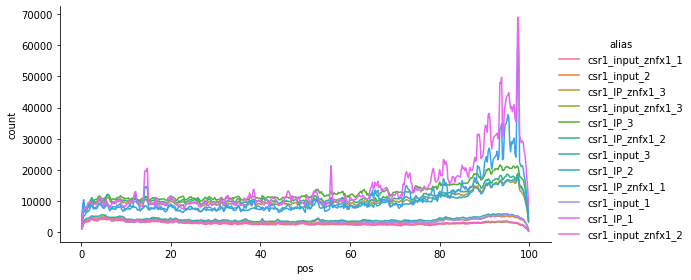

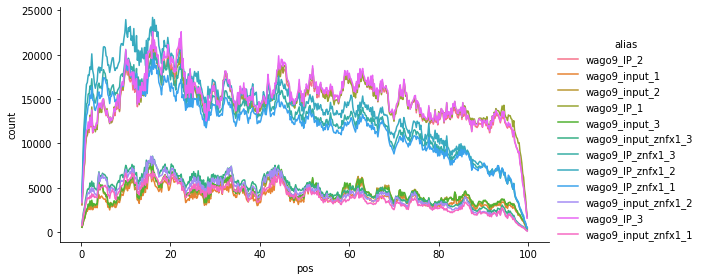

In [19]:
# full length 
csr = run_metagene(glob.glob(f"{bed_input}/*csr*.rpm"), 
             bed_windows = "csr.full.bed", 
             scaling = True,
             transcripts = None,
             sample = "upstream", 
             p5nt = ['G', 'A'], 
             min_len = 21, 
             max_len = 23)

wago = run_metagene(glob.glob(f"{bed_input}/*wago*.rpm"), 
             bed_windows = "hrde.full.bed", 
             scaling = True,
             transcripts = None,
             sample = "upstream", 
             p5nt = ['G', 'A'], 
             min_len = 21, 
             max_len = 23)

In [22]:
conditions = pd.read_csv("/fs/ess/PAS1473/znfx1_CSRIP_WAGO9IP/metagene_alignment/samples/replicates.csv", sep = ',')

In [24]:
csr.head()

,pos,alias,type,count
0,0.2,csr1_input_znfx1_1,density,1058.601422
1,0.4,csr1_input_znfx1_1,density,1946.929648
2,0.6,csr1_input_znfx1_1,density,2768.895583
3,0.8,csr1_input_znfx1_1,density,3050.142197
4,1.0,csr1_input_znfx1_1,density,3234.883538


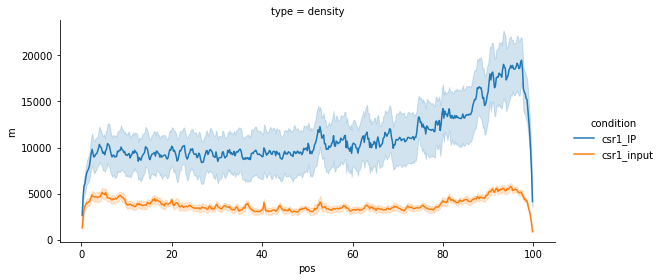

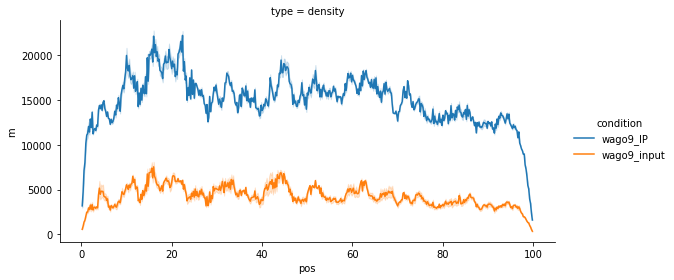

In [27]:
merge_and_plot(conditions, csr.query('~alias.str.contains("IP_1") and ~alias.str.contains("znf")').reset_index(), count = 'count', vline = False)
merge_and_plot(conditions, wago.query('~alias.str.contains("IP_1") and ~alias.str.contains("znf")').reset_index(), count = 'count', vline = False)


# Calculate density in window per gene for CSR-1 targets

In [28]:
%%bash

cat '/fs/ess/PCON0160/ben/genomes/c_elegans/WS279/lincRNA_protein_coding.csr.processed.bed' | grep -w upstream_last_exon > upstream_last_exon_csr.bed
cat '/fs/ess/PCON0160/ben/genomes/c_elegans/WS279/lincRNA_protein_coding.csr.processed.bed' | grep -w last_exon > last_exon_csr.bed
cat '/fs/ess/PCON0160/ben/genomes/c_elegans/WS279/lincRNA_protein_coding.csr.processed.bed' | grep -w three_prime_utr > three_prime_utr_csr.bed


cat '/fs/ess/PCON0160/ben/genomes/c_elegans/WS279/lincRNA_protein_coding.hrde.processed.bed' | grep -w upstream_last_exon > upstream_last_exon_hrde.bed
cat '/fs/ess/PCON0160/ben/genomes/c_elegans/WS279/lincRNA_protein_coding.hrde.processed.bed' | grep -w last_exon > last_exon_hrde.bed
cat '/fs/ess/PCON0160/ben/genomes/c_elegans/WS279/lincRNA_protein_coding.hrde.processed.bed' | grep -w three_prime_utr > three_prime_utr_hrde.bed


In [29]:
upstream_eejunc = run_counting(glob.glob(f"{bed_input}/*csr1*.rpm"), 
             bed_windows = "upstream_last_exon_csr.bed", 
             scaling = False,
             transcripts = None,
             sample = "upstream_last_exon", 
             p5nt = ['G', 'A'], 
             min_len = 21, 
             max_len = 23)

upstream_eejunc.to_csv("upstream_last_exon_csr.tsv", sep = "\t", header = True, index = False)

last_exon = run_counting(glob.glob(f"{bed_input}/*csr1*.rpm"), 
             bed_windows = "last_exon_csr.bed", 
             scaling = False,
             transcripts = None,
             sample = "last_exon", 
             p5nt = ['G', 'A'], 
             min_len = 21, 
             max_len = 23)

last_exon.to_csv("last_exon_csr.tsv", sep = "\t", header = True, index = False)

three_prime_utr_csr = run_counting(glob.glob(f"{bed_input}/*csr1*.rpm"), 
             bed_windows = "three_prime_utr_csr.bed", 
             scaling = False,
             transcripts = None,
             sample = "three_prime_utr", 
             p5nt = ['G', 'A'], 
             min_len = 21, 
             max_len = 23)

three_prime_utr_csr.to_csv("three_prime_utr_csr.tsv", sep = "\t", header = True, index = False)

In [30]:
upstream_eejunc = run_counting(glob.glob(f"{bed_input}/*csr1*.rpm"), 
             bed_windows = "upstream_last_exon_hrde.bed", 
             scaling = False,
             transcripts = None,
             sample = "upstream_last_exon", 
             p5nt = ['G', 'A'], 
             min_len = 21, 
             max_len = 23)

upstream_eejunc.to_csv("upstream_last_exon_hrde.tsv", sep = "\t", header = True, index = False)

last_exon = run_counting(glob.glob(f"{bed_input}/*csr1*.rpm"), 
             bed_windows = "last_exon_hrde.bed", 
             scaling = False,
             transcripts = None,
             sample = "last_exon", 
             p5nt = ['G', 'A'], 
             min_len = 21, 
             max_len = 23)

last_exon.to_csv("last_exon_hrde.tsv", sep = "\t", header = True, index = False)

three_prime_utr_csr = run_counting(glob.glob(f"{bed_input}/*csr1*.rpm"), 
             bed_windows = "three_prime_utr_hrde.bed", 
             scaling = False,
             transcripts = None,
             sample = "three_prime_utr", 
             p5nt = ['G', 'A'], 
             min_len = 21, 
             max_len = 23)

three_prime_utr_csr.to_csv("three_prime_utr_hrde.tsv", sep = "\t", header = True, index = False)